#### 1) Imports and Random Seed


In [28]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models
import os
import random


In [29]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#### 2) Define Dataset


In [30]:
class ImageRatingDataset(Dataset):
    
    def __init__(self, dataframe, transform=None, augment=False, phase=''):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.augment = augment
        self.phase=phase

        # Define augmentations
        self.augmentation = transforms.Compose([
            
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # small rotations
            transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
        ])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        rating = self.dataframe.loc[idx, 'MOS_ZScore']
        
        if self.phase == 'train':
            image = Image.open("../../dataset/images/train_images/" + img_path).convert('RGB')
        elif self.phase == 'test':
            image = Image.open("../../dataset/images/test_images/" + img_path).convert('RGB')
        
        if self.augment == True:
            image = self.augmentation(image)
            
        image_np = np.asarray(image, dtype=np.float32)
        image = torch.tensor(image_np)
        image = image.permute(2, 0, 1)
        
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


#### 3) Define Model


In [31]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        base_model = models.resnet18(pretrained=True)

        # Remove the final classification layer
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Excludes fc layer

        # Freeze base layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)             # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 512)
        x = self.regressor(x)
        return x


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetRegressor().to(device)


/Users/annimukh/miniconda3/envs/image_realness/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annimukh/miniconda3/envs/image_realness/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 230,145


#### 4) Load the Dataset


In [34]:
test_df = pd.read_csv("../../dataset/ratings/test.csv")

test_dataset = ImageRatingDataset(test_df, phase='test')
test_loader = DataLoader(test_dataset, batch_size=32)


#### 5) Load the pre-trained Model


In [35]:
checkpoint_path = "./weights/resnet18_transf-learn-wts.pth"    # your .pth file

if torch.cuda.is_available():
    model.load_state_dict(torch.load(checkpoint_path))
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu")))


/var/folders/l4/8h7869116bj2w59cq06rwl8c0000gn/T/ipykernel_28010/2864128189.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_p

#### 6) Evaluate the model


In [36]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(spearman_corr, pearson_corr)


0.6684528954191875 0.73948807


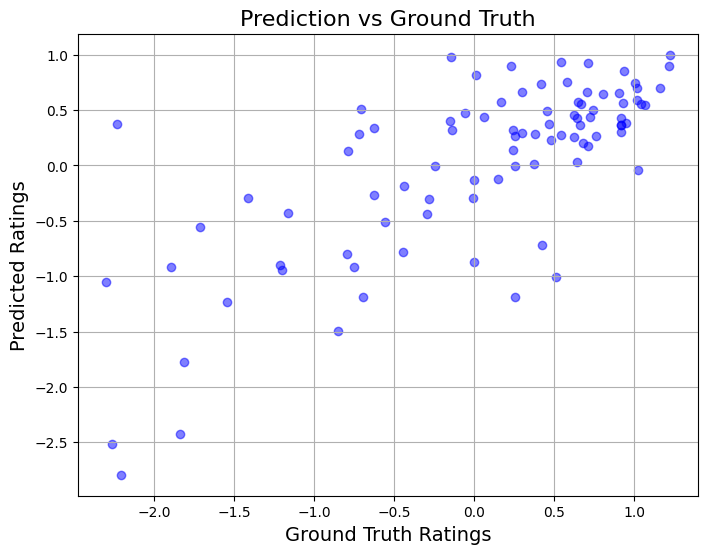

0.6684528954191875 0.73948807


In [37]:
predictions = []
ground_truths = []

with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device)  
        ratings = ratings.to(device)

        predicted_ratings = model(images)

        predictions.extend(predicted_ratings.cpu().numpy())  
        ground_truths.extend(ratings.cpu().numpy())  


predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()


plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)
